#emotion detector

In [30]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.15.0


**exploring dataset**


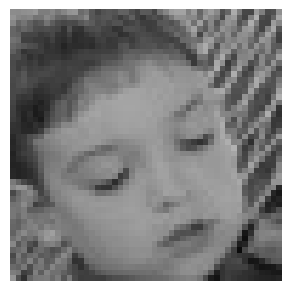

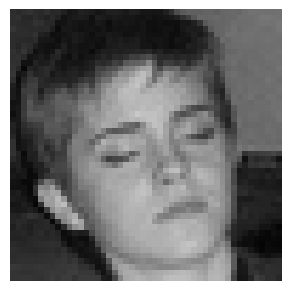

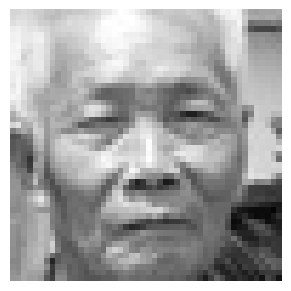

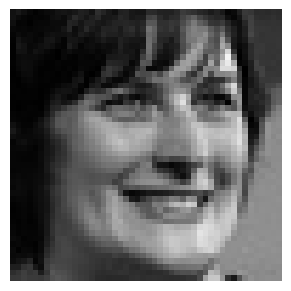

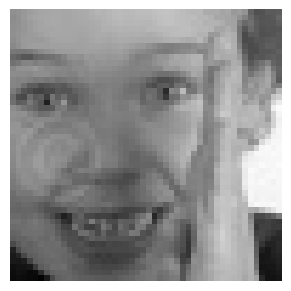

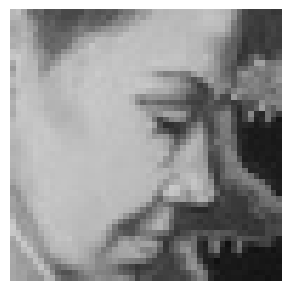

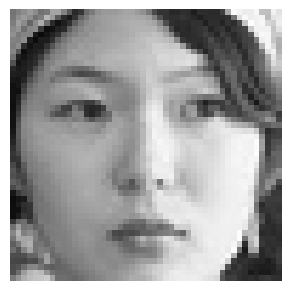

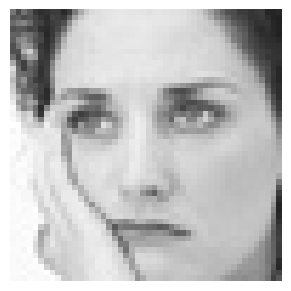

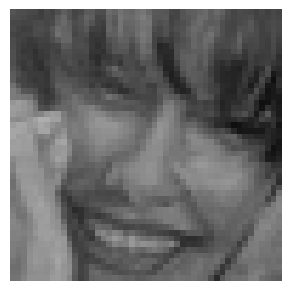

In [31]:
images = glob("train/**/**")
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis('off')

In [16]:
#prepearing data for training


In [45]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator()
train_generator = datagen_train.flow_from_directory("train/",
                                                   target_size = (img_size,img_size),
                                                   color_mode = "grayscale",
                                                   batch_size = batch_size,
                                                   class_mode = "categorical",
                                                   shuffle = True)

datagen_validation = ImageDataGenerator()
validation_generator = datagen_train.flow_from_directory("test/",
                                                   target_size = (img_size,img_size),
                                                   color_mode = "grayscale",
                                                   batch_size = batch_size,
                                                   class_mode = "categorical",
                                                   shuffle = True)

Found 25795 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [18]:
#defining model 

In [33]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)
    
    return x

In [34]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    
    return x


In [35]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs,32,(3,3))
    conv_2 = Convolution(conv_1,64,(5,5))
    conv_3 = Convolution(conv_2,128,(3,3))

    flatten = Flatten()(conv_3)
    
    dense_1 = Dense_f(flatten,256)

    output  = Dense(7, activation="softmax")(dense_1)
    model  =  Model(inputs=[inputs],outputs = [output])
    
    model.compile(loss=['categorical_crossentropy'] , optimizer = 'adam' , metrics =["accuracy"])

    return model

In [36]:
model = model_fer((48,48,1))
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 batch_normalization_8 (Bat  (None, 48, 48, 32)        128       
 chNormalization)                                                
                                                                 
 activation_8 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 24, 24, 32)        0   

In [23]:
#intializing the model

In [37]:
epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.h5", monitor  ='val_accuracy', save_weights_only = True, mode = 'max', verbose =1)
callbacks = [checkpoint]

In [25]:
#training the model

In [38]:
history = model.fit(
x = train_generator,
steps_per_epoch = steps_per_epoch,
epochs = epochs,
validation_data = validation_generator,
validation_steps = validation_steps,
callbacks = callbacks)

Epoch 1/15
403/403 [==============================] - ETA: 0s - loss: 1.6294 - accuracy: 0.3624
Epoch 1: saving model to model_weights.h5
403/403 [==============================] - 88s 206ms/step - loss: 1.6294 - accuracy: 0.3624 - val_loss: 2.1426 - val_accuracy: 0.3398
Epoch 2/15
403/403 [==============================] - ETA: 0s - loss: 1.3785 - accuracy: 0.4624
Epoch 2: saving model to model_weights.h5
403/403 [==============================] - 67s 166ms/step - loss: 1.3785 - accuracy: 0.4624 - val_loss: 1.7703 - val_accuracy: 0.4289
Epoch 3/15
403/403 [==============================] - ETA: 0s - loss: 1.2723 - accuracy: 0.5065
Epoch 3: saving model to model_weights.h5
403/403 [==============================] - 70s 172ms/step - loss: 1.2723 - accuracy: 0.5065 - val_loss: 1.5639 - val_accuracy: 0.4513
Epoch 4/15
403/403 [==============================] - ETA: 0s - loss: 1.1909 - accuracy: 0.5360
Epoch 4: saving model to model_weights.h5
403/403 [==============================] - 72s

In [ ]:
#model evaluation 

In [39]:
model.evaluate(validation_generator)

113/113 [==============================] - 15s 136ms/step - loss: 1.3388 - accuracy: 0.5419


[1.3388243913650513, 0.5419337153434753]

In [40]:
#plotting loss

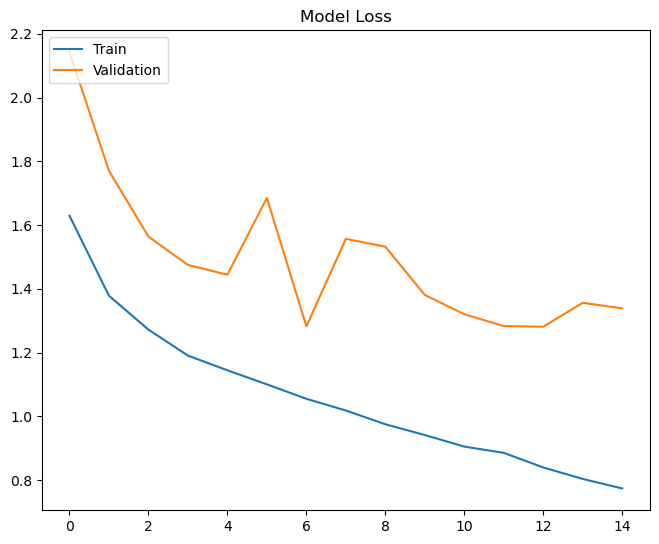

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.25,wspace=0.35)

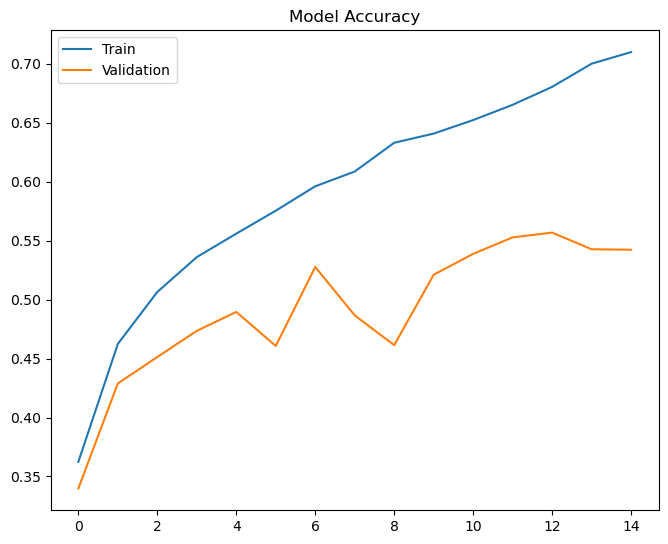

In [42]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.25,wspace=0.35)

In [43]:
#saving model

In [44]:
model_json = model.to_json()
with open("model_a.json","w") as json_file:
    json_file.write(model_json)